In [2]:
import numpy as np
import pandas as pd
import scanpy as sc

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
results_file = './write/pbmc3k.h5ad'  # the file that will store the analysis results

scanpy==1.4.4.post1 anndata==0.6.22.post1 umap==0.3.9 numpy==1.16.4 scipy==1.3.0 pandas==0.25.0 scikit-learn==0.21.2 statsmodels==0.10.1


In [14]:
df = pd.read_csv('/home/aliu/omics4tb2/aliu/projects/causalAssociation/results/expected/GSM3587977_AML707B-D97.dem.txt', sep='\t', header = 0, index_col = 0, engine='python')
# dfTranspose = df.T
# 

# write all gene ids to gene_names.txt
# gene_ids = df.index.tolist()
# with open('./gene_names.txt', 'a+') as file:
#     for item in gene_ids:
#         file.write("%s\n" % item)
new_genes_index = []   
### use https://biodbnet-abcc.ncifcrf.gov/db/db2db.php to get ensembl gene id for gene symbol
df_gene_conversion = pd.read_csv('/home/aliu/omics4tb2/aliu/projects/causalAssociation/src/gene_symbol_to_ensembl.txt', sep='\t', header = 0, index_col = 0, engine='python')
df_gene_conversion['Ensembl Gene ID'].apply(lambda x: x.split("; ")[4])

# dfTranspose.to_csv('/home/aliu/omics4tb2/aliu/projects/causalAssociation/results/expected/GSM3587977_AML707B-D97.transpose.dem.txt', sep='\t')

Gene,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2MP1,A3GALT2,A4GALT,A4GNT,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
AML707B-D97_AAAAGGCTGAGA,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AML707B-D97_AACTTTGTGCCG,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
AML707B-D97_AATTGAGTGCTN,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AML707B-D97_ACACTTGACTAA,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
AML707B-D97_ACCCGCGAAGAC,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AML707B-D97_ACCGTCTTTGAC,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AML707B-D97_ACTAGATTCGAG,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
AML707B-D97_ACTATTCAACGG,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AML707B-D97_ACTTAGTCGGTC,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AML707B-D97_AGAGATTGACAG,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
df=pd.DataFrame({'x': range(1,11), 'y1': np.random.randn(10), 'y2': np.random.randn(10)+range(1,11), 'y3': np.random.randn(10)+range(11,21) })
df

,x,y1,y2,y3
0,1,-1.585970,1.991190,11.648527
1,2,0.771703,2.973144,13.120634
2,3,0.700776,2.967814,13.325885
3,4,0.007495,3.481979,15.063868
4,5,0.997116,4.141697,14.691376
5,6,0.242003,6.136291,16.613067
6,7,-1.959965,5.299513,17.757909
7,8,-0.056668,6.629944,18.857779
8,9,0.021235,7.535058,18.296938
9,10,0.569656,9.041466,20.365546


In [12]:
# import data as AnnData
adata = sc.read_csv('/home/aliu/omics4tb2/aliu/projects/causalAssociation/results/expected/GSM3587977_AML707B-D97.transpose.dem.txt', delimiter='\t', )
adata

AnnData object with n_obs × n_vars = 84 × 27899 

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


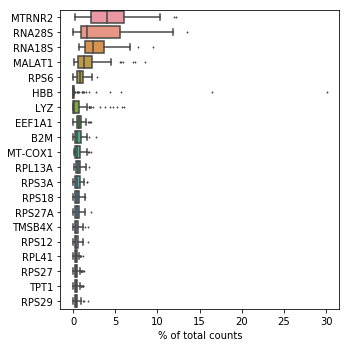

In [13]:
sc.pl.highest_expr_genes(adata, n_top=20)

In [14]:
# basic filtering
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 20962 genes that are detectedin less than 3 cells


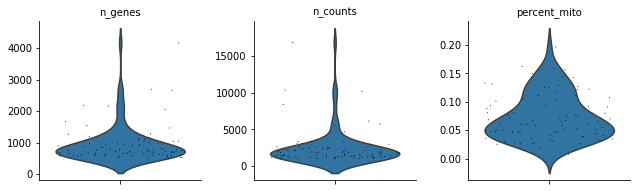

In [15]:
mito_genes = adata.var_names.str.startswith('MT')
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1) / np.sum(adata.X, axis=1)
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1)

# create violin plot
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],
             jitter=0.4, multi_panel=True)

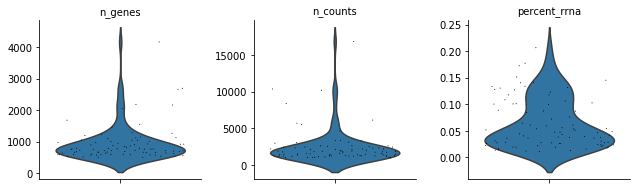

In [16]:
rrna_transcript = adata.var_names.str.startswith('RNA')
# for each cell compute fraction of counts in rrna transcripts vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
adata.obs['percent_rrna'] = np.sum(
    adata[:, rrna_transcript].X, axis=1) / np.sum(adata.X, axis=1)

# create violin plot
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_rrna'],
             jitter=0.4, multi_panel=True)

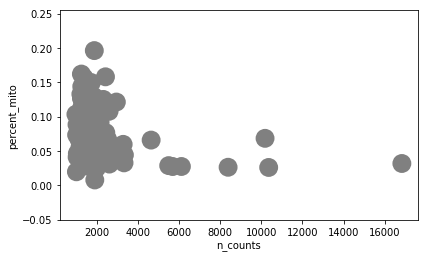

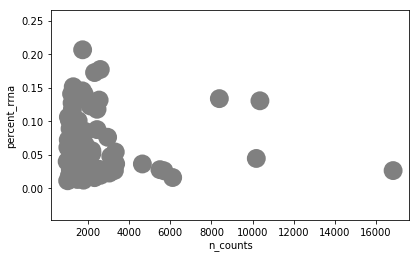

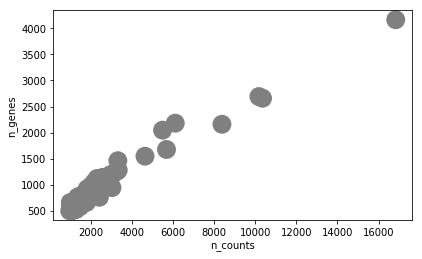

In [17]:
sc.pl.scatter(adata, x='n_counts', y='percent_mito')
sc.pl.scatter(adata, x='n_counts', y='percent_rrna')
sc.pl.scatter(adata, x='n_counts', y='n_genes')

In [18]:
# filter out cells with high mito gene expression or not many genes expressed
adata = adata[adata.obs['n_genes'] < 2500, :]
adata = adata[adata.obs['percent_mito'] < 0.15, :]
adata = adata[adata.obs['percent_rrna'] < 0.15, :]

In [20]:
# normalize total counts in each cell to 10,000 so that cells are comparable
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
# log
sc.pp.log1p(adata)
# freeze state of adata object
adata.raw = adata

normalizing by total count per cell


Trying to set attribute `.obs` of view, making a copy.


    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


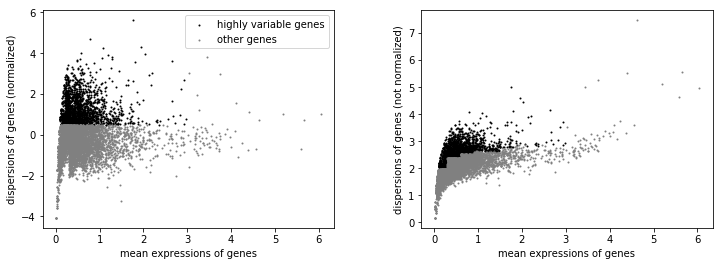

In [21]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata)

In [22]:
# filter out non highly variable genes
adata = adata[:, adata.var['highly_variable']]

sc.pp.regress_out(adata, ['n_counts', 'percent_mito'])
sc.pp.regress_out(adata, ['n_counts', 'percent_rrna'])

regressing out ['n_counts', 'percent_mito']
    finished (0:00:02)
regressing out ['n_counts', 'percent_rrna']
    finished (0:00:02)


In [24]:
# scale each gene to unit variance, max value set to 10
sc.pp.scale(adata, max_value=10)

computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:00)


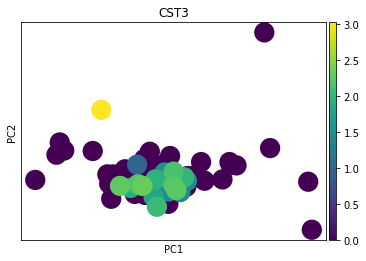

In [26]:
# PCA analysis
sc.tl.pca(adata, svd_solver='arpack', n_comps = 50)
sc.pl.pca(adata, color='CST3')

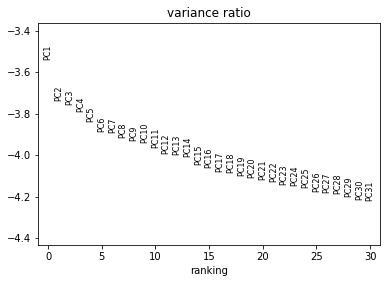

In [27]:
sc.pl.pca_variance_ratio(adata, log=True)

In [28]:
adata.write(results_file)
adata

AnnData object with n_obs × n_vars = 73 × 1871 
    obs: 'n_genes', 'percent_mito', 'n_counts', 'percent_rrna'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'